# KNN

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import StandardScaler
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set directories
print(os.getcwd())
dirRawData = "../rawdata/"
dirPData = "../pydata/"
dirOutput = "../output/"

/home/jovyan/work/aml_cw/code


In [3]:
def fn_MAE(actuals, predictions):
    return np.round(np.mean(np.abs(predictions - actuals)))

def fn_RMSE(actuals, predictions):
    return np.round(np.sqrt(np.mean((predictions - actuals)**2)))

In [4]:
# Load up data - df_all

f_name = dirPData + 'df_all.pickle'

with (open(f_name, "rb")) as f:
    dict_ = pickle.load(f)

df_all = dict_['df_all_onehot']

del f_name, dict_

In [5]:
# Load up data - df_all

f_name = dirPData + 'df_test_onehot.pickle'

with (open(f_name, "rb")) as f:
    dict_ = pickle.load(f)

df_test = dict_['df_test_all_onehot']

del f_name, dict_

In [6]:
# load the variables information
f_name = dirPData + 'variables.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
var_dep = dict_['var_dep']
vars_ind_numeric = dict_['vars_ind_numeric']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_ind_onehot = dict_['vars_ind_onehot']

del dict_

In [7]:
df_all.shape

(11962, 486)

In [8]:
df_test.shape

(5121, 455)

In [10]:
testcols = list(df_test.columns)

In [11]:
dfcols = list(df_all.columns)

In [20]:
missing_cols = [var for var in df_all if var not in df_test]
missing_cols.remove('fold')
missing_cols.remove('target')

In [21]:
missing_cols

['v_char_2_X_L',
 'v_char_9_X_c',
 'v_char_13_X_B',
 'v_char_28_X_h',
 'v_char_29_X_s',
 'v_char_34_X_Y',
 'v_char_38_X_l',
 'v_char_45_X_H',
 'v_char_48_X_D',
 'v_char_52_X_L',
 'v_char_54_X_S',
 'v_char_57_X_o',
 'v_char_59_X_Z',
 'v_char_72_X_P',
 'v_char_72_X_f',
 'v_char_79_X_o',
 'v_char_80_X_h',
 'v_char_88_X_S',
 'v_char_89_X_W',
 'v_char_90_X_X',
 'v_char_92_X_E',
 'v_char_100_X_H',
 'v_char_100_X_d',
 'v_char_100_X_m',
 'v_char_100_X_s',
 'v_char_100_X_x',
 'v_char_106_X_G',
 'v_char_109_X_B',
 'v_char_109_X_M',
 'v_char_112_X_J',
 'v_char_112_X_P',
 'v_char_112_X_g',
 'v_char_114_X_Y']

In [29]:
df_test = df_test.reindex(columns=[*df_test.columns.tolist(), *missing_cols], fill_value=0)

In [37]:
df_test.shape

(5121, 484)

In [33]:
testing_cols = [var for var in df_test if var not in df_all]
testing_cols

['v_char_27_X_g', 'v_char_39_X_S', 'v_char_100_X_X', 'v_char_100_X_t']

In [36]:
df_test= df_test.drop(columns=testing_cols, axis=1)

## Processing done!

In [38]:
vars_ind = vars_ind_numeric + vars_ind_onehot

In [39]:
idx_train  = np.where(df_all['fold'].isin(np.arange(0,6)))[0]
idx_val    = np.where(df_all['fold'].isin([6,7]))[0]
idx_design = np.where(df_all['fold'].isin(np.arange(0,8)))[0]
idx_test   = np.where(df_all['fold'].isin([8,9]))[0]

In [40]:
n_train = len(idx_train)
n_val = len(idx_val)
n_test = len(idx_test)

In [59]:
X = df_all[vars_ind].values

# Standardise (each feature to have mean:0 and stdev:1)
# This should not use the test data.  Why not?
X_train  = X[idx_train, :]

standardScaler_ = StandardScaler()
standardScaler_.fit(X_train)

# Now standardise all the data
X = standardScaler_.transform(X)

In [60]:
X_design = X[idx_design, :]
X_train  = X[idx_train, :]
X_val    = X[idx_val, :]
X_test   = X[idx_test, :]

y_design = df_all[var_dep].iloc[idx_design].copy().values.ravel()
y_train  = df_all[var_dep].iloc[idx_train].copy().values.ravel()
y_val    = df_all[var_dep].iloc[idx_val].copy().values.ravel()
y_test   = df_all[var_dep].iloc[idx_test].copy().values.ravel()

In [61]:
sknn_ = KNeighborsClassifier(n_neighbors=1, 
                            weights='uniform',
                            algorithm='brute', 
                            p=2, 
                            metric='minkowski')
sknn_.fit(X_train, y_train)
sknn_pred_val = sknn_.predict(X_val)

print('predictions of the first 5 ids in val:')
#print('numpy: ' ,nn_pred_val[0:5])
print('sklearn:', sknn_pred_val[0:5])

predictions of the first 5 houses in val:
sklearn: [0 0 0 0 0]


In [62]:
k_range = range(1, 32)
mae_k = np.zeros(len(k_range))
for k in range(1, 32):
    sknn_ = KNeighborsClassifier(n_neighbors=k, 
                                weights='uniform',
                                algorithm='auto', 
                                p=2, 
                                metric='minkowski')
    sknn_.fit(X_train, y_train)
    sknn_pred_val = sknn_.predict(X_val)
    mae_k[k - 1] = np.mean(np.abs(y_val - sknn_pred_val))


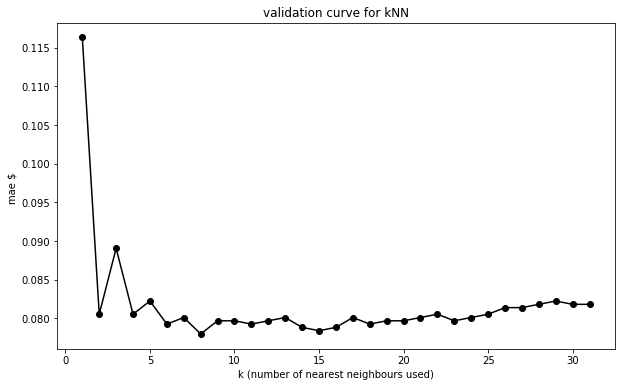

In [63]:
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(k_range, mae_k, 'ko-')
ax1.set_xlabel('k (number of nearest neighbours used)')
ax1.set_ylabel('mae $ ')
_ = plt.title('validation curve for kNN')


In [64]:
best_k = 1 + np.argmin(mae_k)
best_k

8

In [65]:
sknn_ = KNeighborsClassifier(n_neighbors=best_k, 
                            weights='uniform',
                            algorithm='auto', 
                            p=2, 
                            metric='minkowski')
sknn_.fit(X_design, y_design)
sknn_pred_test = sknn_.predict(X_test)
print('MAE on the test data, using k = ', best_k)
print(np.mean(np.abs(y_test - sknn_pred_test)))

MAE on the test data, using k =  8
0.08852459016393442


In [66]:
sknn_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
#df_test = pd.read_csv(dirRawData + 'test.csv')

In [67]:
df_test_id = df_test[['id']]
df_test_var = df_test.loc[:, df_test.columns != 'id']

In [68]:
df_test_var.shape

(5121, 483)

In [69]:
X_train.shape

(7175, 483)

In [73]:
sknn_predictions = sknn_.predict_proba(df_test_var)

In [74]:
df_sknn = pd.DataFrame(sknn_predictions)

In [75]:
df_sknn.tail()

,0,1
5116,0.875,0.125
5117,1.000,0.000
5118,0.875,0.125
5119,0.875,0.125
5120,0.875,0.125


In [76]:
df_submission = df_test.loc[:,['id']]
df_submission = df_submission.join(df_sknn[1])
#df_sumission = df_submission.join(df_test['1'])

In [77]:
df_submission.columns = ['id', 'target']
df_submission.tail()

,id,target
5116,17074,0.125
5117,17076,0.000
5118,17079,0.125
5119,17082,0.125
5120,17083,0.125


In [78]:
df_submission.to_csv(dirOutput+ 'knn_onehot_prob.csv', index=False)

In [79]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121 entries, 0 to 5120
Data columns (total 2 columns):
id        5121 non-null int64
target    5121 non-null float64
dtypes: float64(1), int64(1)
memory usage: 80.1 KB
